# Temat 2
#### Przewidywanie wzięcia pożyczki. Celem projektu jest zastosowanie modeli  klasyfikacji (binarnej) doprzewidzenia czy pożyczka zostanie udzielona danemu klientowi z danymi parametrami wniosku.

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
import seaborn as sns

# Sekcja 1 - przygotowanie danych

In [121]:
url="https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv"
raw_data=pd.read_csv(url,encoding='latin–1',delimiter=',')

print(raw_data.head())

            ID  Gender       City  Monthly_Income        DOB  \
0  ID000002C20  Female      Delhi           20000  23-May-78   
1  ID000004E40    Male     Mumbai           35000  07-Oct-85   
2  ID000007H20    Male  Panchkula           22500  10-Oct-81   
3  ID000008I30    Male    Saharsa           35000  30-Nov-87   
4  ID000009J40    Male  Bengaluru          100000  17-Feb-84   

  Lead_Creation_Date  Loan_Amount_Applied  Loan_Tenure_Applied  Existing_EMI  \
0          15-May-15             300000.0                  5.0           0.0   
1          04-May-15             200000.0                  2.0           0.0   
2          19-May-15             600000.0                  4.0           0.0   
3          09-May-15            1000000.0                  5.0           0.0   
4          20-May-15             500000.0                  2.0       25000.0   

                         Employer_Name  ... Interest_Rate Processing_Fee  \
0                              CYBOSOL  ...           NaN 

In [122]:
# usuwam dwie kolumny zgodnie z wytycznymi i opisem danych "can not be used for predictions"
data=raw_data.drop(columns=['ID', 'LoggedIn'])
print(data.head())

   Gender       City  Monthly_Income        DOB Lead_Creation_Date  \
0  Female      Delhi           20000  23-May-78          15-May-15   
1    Male     Mumbai           35000  07-Oct-85          04-May-15   
2    Male  Panchkula           22500  10-Oct-81          19-May-15   
3    Male    Saharsa           35000  30-Nov-87          09-May-15   
4    Male  Bengaluru          100000  17-Feb-84          20-May-15   

   Loan_Amount_Applied  Loan_Tenure_Applied  Existing_EMI  \
0             300000.0                  5.0           0.0   
1             200000.0                  2.0           0.0   
2             600000.0                  4.0           0.0   
3            1000000.0                  5.0           0.0   
4             500000.0                  2.0       25000.0   

                         Employer_Name       Salary_Account  ...  \
0                              CYBOSOL            HDFC Bank  ...   
1  TATA CONSULTANCY SERVICES LTD (TCS)           ICICI Bank  ...   
2       

In [123]:
# dzielę dane na  dwie bazy
y=data['Disbursed']

X=data.drop(columns=['Disbursed'], axis=1)


In [124]:
# sprawdzam ktore wartości mają Nan-y/nulle
X.isnull().sum()

Gender                       0
City                      1003
Monthly_Income               0
DOB                          0
Lead_Creation_Date           0
Loan_Amount_Applied         71
Loan_Tenure_Applied         71
Existing_EMI                71
Employer_Name               71
Salary_Account           11764
Mobile_Verified              0
Var5                         0
Var1                         0
Loan_Amount_Submitted    34613
Loan_Tenure_Submitted    34613
Interest_Rate            59294
Processing_Fee           59600
EMI_Loan_Submitted       59294
Filled_Form                  0
Device_Type                  0
Var2                         0
Source                       0
Var4                         0
dtype: int64

In [125]:
# sprawdzam, które są zmiennymi kategorycznymi
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 87020 non-null  object 
 1   City                   86017 non-null  object 
 2   Monthly_Income         87020 non-null  int64  
 3   DOB                    87020 non-null  object 
 4   Lead_Creation_Date     87020 non-null  object 
 5   Loan_Amount_Applied    86949 non-null  float64
 6   Loan_Tenure_Applied    86949 non-null  float64
 7   Existing_EMI           86949 non-null  float64
 8   Employer_Name          86949 non-null  object 
 9   Salary_Account         75256 non-null  object 
 10  Mobile_Verified        87020 non-null  object 
 11  Var5                   87020 non-null  int64  
 12  Var1                   87020 non-null  object 
 13  Loan_Amount_Submitted  52407 non-null  float64
 14  Loan_Tenure_Submitted  52407 non-null  float64
 15  In

In [126]:
# sprawdzam czy zmienna Y przyjmuje wartości 1 i 0
data['Disbursed'].value_counts()

0    85747
1     1273
Name: Disbursed, dtype: int64

In [127]:
# tej zmiennej nie mogę użyć w modelu, ponieważ najwiecej jest wartości pustych - 
# wypełnienie ich najczęściej występującą daną zaburzyłoby zbiór, dodatkowo jest wiele pojedynczych wystąpień

X["Employer_Name"].value_counts()

z = X["Employer_Name"].value_counts().rename_axis("unique_Name").reset_index(name='counts')
z

,unique_Name,counts
0,0,4914
1,TATA CONSULTANCY SERVICES LTD (TCS),550
2,COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,404
3,ACCENTURE SERVICES PVT LTD,324
4,GOOGLE,301
...,...,...
43562,LEE BOY INDIA CONSTRUCTION P V T L T D,1
43563,WEST COAST FINE FOODS INDIA PVT. LTD.,1
43564,FAIR LAWNS STUD FARMS PVT LTD,1
43565,ORISSA KNOWLEDGE POWER CORPORTION,1


In [128]:
# zgodnie z powyższym

X = X.drop("Employer_Name",axis=1)

In [129]:
# używam daty urodzenia i złożenia wniosku do wyznaczenia wieku - same daty nie niosą informacji

X['Lead_Creation_Date'] = pd.to_datetime(X['Lead_Creation_Date'])
X['DOB'] = pd.to_datetime(X['DOB'])
X['Age'] = (X['Lead_Creation_Date'] - X['DOB'])
X['Age'] = X['Age'].astype('timedelta64[Y]')

In [130]:
# usuwam pośrednie kolumny
X = X.drop(['Lead_Creation_Date', 'DOB'], axis=1)

In [131]:
# zmienne kategoryczne wyciągam, uzupełnia braki 

cat= X.select_dtypes(include=[object])
imp=SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
idf=pd.DataFrame(imp.fit_transform(cat))
idf.columns=cat.columns
idf.index=cat.index
idf

,Gender,City,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
0,Female,Delhi,HDFC Bank,N,HBXX,N,Web-browser,G,S122
1,Male,Mumbai,ICICI Bank,Y,HBXA,N,Web-browser,G,S122
2,Male,Panchkula,State Bank of India,Y,HBXX,N,Web-browser,B,S143
3,Male,Saharsa,State Bank of India,Y,HBXX,N,Web-browser,B,S143
4,Male,Bengaluru,HDFC Bank,Y,HBXX,N,Web-browser,B,S134
...,...,...,...,...,...,...,...,...,...
87015,Female,Ajmer,ICICI Bank,N,HBXX,N,Web-browser,G,S122
87016,Female,Kochi,Federal Bank,Y,HBXB,Y,Mobile,G,S122
87017,Male,Bengaluru,Syndicate Bank,Y,HBXX,N,Mobile,G,S122
87018,Male,Bengaluru,ICICI Bank,Y,HBXX,N,Web-browser,G,S122


In [132]:
# zamieniam kategoryczne na numeryczne - LabelEncoder dla binarnych

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Konweruje kolumny w X podane w self.columns używając
        LabelEncoder().Jeśli nie są podane to konwertuj wszytskie kolumny w X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [133]:
idf_encoded =MultiColumnLabelEncoder(columns = ['Gender', 'Mobile_Verified', 'Filled_Form', 'Device_Type'])\
                                    .fit_transform(idf)
idf_encoded

,Gender,City,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
0,0,Delhi,HDFC Bank,0,HBXX,0,1,G,S122
1,1,Mumbai,ICICI Bank,1,HBXA,0,1,G,S122
2,1,Panchkula,State Bank of India,1,HBXX,0,1,B,S143
3,1,Saharsa,State Bank of India,1,HBXX,0,1,B,S143
4,1,Bengaluru,HDFC Bank,1,HBXX,0,1,B,S134
...,...,...,...,...,...,...,...,...,...
87015,0,Ajmer,ICICI Bank,0,HBXX,0,1,G,S122
87016,0,Kochi,Federal Bank,1,HBXB,1,0,G,S122
87017,1,Bengaluru,Syndicate Bank,1,HBXX,0,0,G,S122
87018,1,Bengaluru,ICICI Bank,1,HBXX,0,1,G,S122


In [134]:
# zamieniam kategoryczne na numeryczne - dla kolumn z większą ilością wartości

categorical = pd.get_dummies(idf_encoded)
categorical

,Gender,Mobile_Verified,Filled_Form,Device_Type,City_ADIPUR,City_AHMEDB,City_AMALSAD,City_ANJAR,City_Abohar,City_Adilabad,...,Source_S153,Source_S154,Source_S155,Source_S156,Source_S157,Source_S158,Source_S159,Source_S160,Source_S161,Source_S162
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87016,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87017,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87018,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
# zmienne numeryczne wyciągam, uzupełnia braki medianą

num = X.select_dtypes(exclude=[object])
imp = SimpleImputer(missing_values=np.NaN,strategy='median')
ndf = pd.DataFrame(imp.fit_transform(num))
ndf.columns=num.columns
ndf.index=num.index
ndf

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,Age
0,20000.0,300000.0,5.0,0.0,0.0,300000.0,4.0,18.00,4000.0,9392.97,1.0,36.0
1,35000.0,200000.0,2.0,0.0,13.0,200000.0,2.0,13.25,4000.0,6762.90,3.0,29.0
2,22500.0,600000.0,4.0,0.0,0.0,450000.0,4.0,18.00,4000.0,9392.97,1.0,33.0
3,35000.0,1000000.0,5.0,0.0,10.0,920000.0,5.0,18.00,4000.0,9392.97,3.0,27.0
4,100000.0,500000.0,2.0,25000.0,17.0,500000.0,2.0,18.00,4000.0,9392.97,3.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87015,71901.0,1000000.0,5.0,14500.0,9.0,300000.0,4.0,18.00,4000.0,9392.97,3.0,-55.0
87016,16000.0,0.0,0.0,0.0,1.0,240000.0,4.0,35.50,4800.0,9425.76,5.0,24.0
87017,118000.0,0.0,0.0,0.0,8.0,1200000.0,4.0,18.00,4000.0,9392.97,3.0,43.0
87018,98930.0,800000.0,5.0,13660.0,18.0,800000.0,5.0,18.00,4000.0,9392.97,3.0,38.0


In [136]:
# łączę dane kategoryczne i numeryczne

data_prepared = pd.concat([categorical, ndf], axis=1, sort=False)
data_prepared

,Gender,Mobile_Verified,Filled_Form,Device_Type,City_ADIPUR,City_AHMEDB,City_AMALSAD,City_ANJAR,City_Abohar,City_Adilabad,...,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,Age
0,0,0,0,1,0,0,0,0,0,0,...,5.0,0.0,0.0,300000.0,4.0,18.00,4000.0,9392.97,1.0,36.0
1,1,1,0,1,0,0,0,0,0,0,...,2.0,0.0,13.0,200000.0,2.0,13.25,4000.0,6762.90,3.0,29.0
2,1,1,0,1,0,0,0,0,0,0,...,4.0,0.0,0.0,450000.0,4.0,18.00,4000.0,9392.97,1.0,33.0
3,1,1,0,1,0,0,0,0,0,0,...,5.0,0.0,10.0,920000.0,5.0,18.00,4000.0,9392.97,3.0,27.0
4,1,1,0,1,0,0,0,0,0,0,...,2.0,25000.0,17.0,500000.0,2.0,18.00,4000.0,9392.97,3.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,0,0,0,1,0,0,0,0,0,0,...,5.0,14500.0,9.0,300000.0,4.0,18.00,4000.0,9392.97,3.0,-55.0
87016,0,1,1,0,0,0,0,0,0,0,...,0.0,0.0,1.0,240000.0,4.0,35.50,4800.0,9425.76,5.0,24.0
87017,1,1,0,0,0,0,0,0,0,0,...,0.0,0.0,8.0,1200000.0,4.0,18.00,4000.0,9392.97,3.0,43.0
87018,1,1,0,1,0,0,0,0,0,0,...,5.0,13660.0,18.0,800000.0,5.0,18.00,4000.0,9392.97,3.0,38.0


In [137]:
# dzielę bazę danych na treningową i testową przed dalszą obróbką danych, aby uniknąć 'information leakage'

X_train, X_test , y_train, y_test = train_test_split(data_prepared, y, test_size=0.20, random_state = 42)

In [138]:
# Przeprowadzam test chi2, żeby wybrać 10 najlepszych zmiennych do modelu

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


X_best = abs(X_train)  #
y_best = y_train 


bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_best,y_best)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_best.columns)

#łączę nazwy kolumn z wynikami
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(10,'Score'))  

                     Specs         Score
815    Loan_Amount_Applied  4.439876e+07
819  Loan_Amount_Submitted  2.665666e+07
817           Existing_EMI  8.545919e+06
814         Monthly_Income  3.972995e+06
823     EMI_Loan_Submitted  1.672439e+05
822         Processing_Fee  1.074197e+05
818                   Var5  6.042008e+03
816    Loan_Tenure_Applied  2.039872e+02
761              Var1_HAXC  1.880100e+02
760              Var1_HAXB  1.747646e+02


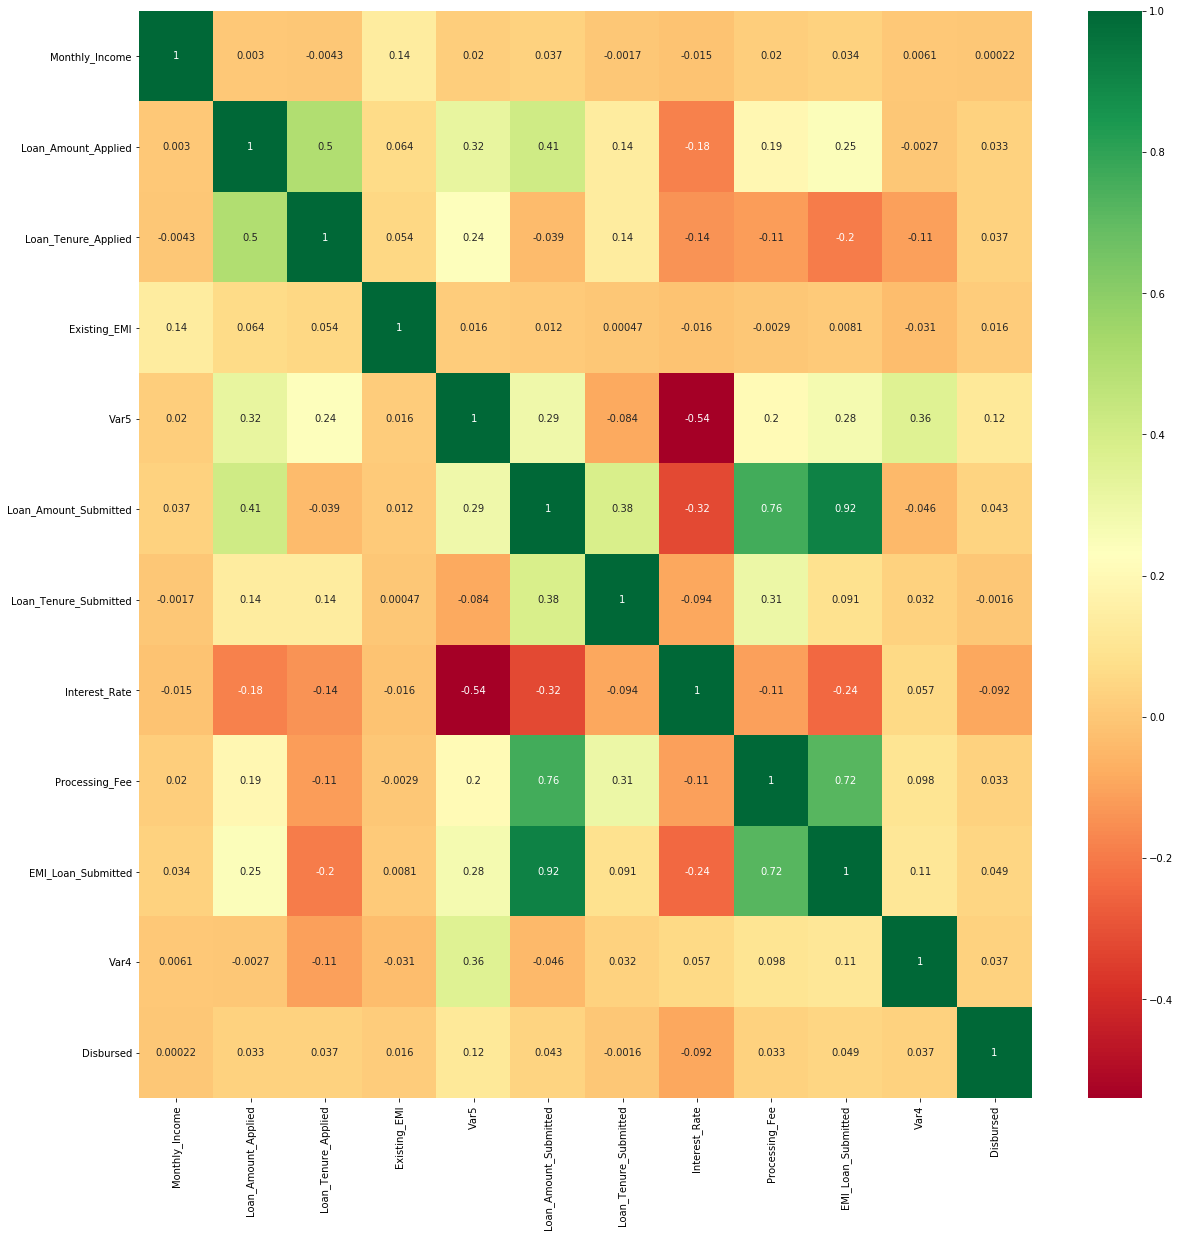

In [139]:
# Sprawdzam też korelację zmiennych do predykowanej wartości - brak silnych korelacji wybranych zmiennych

X = X_train  
y = y_train    


corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))


g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [140]:
# pozostawiam najważniejsze zmienne - zgodnie z wynikami chi2

X_train = X_train[['Loan_Amount_Applied', 'Loan_Amount_Submitted', 'Existing_EMI', 'Monthly_Income',\
                  'EMI_Loan_Submitted', 'Processing_Fee', 'Var5', 'Loan_Tenure_Applied', 'Var1_HAXC',\
                  'Var1_HAXB']]

In [143]:
# scalowanie zmiennych

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)


In [144]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns=X_train.columns
X_train_scaled.head()

,Loan_Amount_Applied,Loan_Amount_Submitted,Existing_EMI,Monthly_Income,EMI_Loan_Submitted,Processing_Fee,Var5,Loan_Tenure_Applied,Var1_HAXC,Var1_HAXB
0,0.756422,-0.028281,-0.084778,-0.036855,-0.118208,-0.132046,-0.699702,1.421729,-0.134666,-0.155132
1,0.195180,0.793130,0.236176,0.018313,3.903132,2.449663,1.948086,-0.068112,7.425762,-0.155132
2,-0.590560,-0.233634,0.005625,-0.033765,-0.118208,-0.132046,-0.876222,-0.564725,-0.134666,-0.155132
3,2.159528,2.641304,-0.084778,0.009494,-0.118208,-0.132046,1.771567,1.421729,-0.134666,-0.155132
4,0.756422,0.587777,-0.084778,0.018764,-0.118208,-0.132046,1.242009,1.421729,-0.134666,-0.155132


In [149]:
#operacje na danych testowych

X_test = X_test[['Loan_Amount_Applied', 'Loan_Amount_Submitted', 'Existing_EMI', 'Monthly_Income',\
                  'EMI_Loan_Submitted', 'Processing_Fee', 'Var5', 'Loan_Tenure_Applied', 'Var1_HAXC',\
                  'Var1_HAXB']]

scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns=X_test.columns
X_test_scaled.head()

,Loan_Amount_Applied,Loan_Amount_Submitted,Existing_EMI,Monthly_Income,EMI_Loan_Submitted,Processing_Fee,Var5,Loan_Tenure_Applied,Var1_HAXC,Var1_HAXB
0,-0.663886,3.441430,-0.371519,-0.003610,4.06182,-1.252011,0.711269,-1.047589,-0.131536,-0.148396
1,-0.663886,-0.239472,-0.371519,-0.017720,-0.12158,-0.130814,-0.870096,-1.047589,-0.131536,-0.148396
2,-0.083903,-0.648461,-0.103207,-0.013913,-0.12158,-0.130814,0.535562,-0.053600,-0.131536,-0.148396
3,-0.663886,1.723676,-0.371519,-0.008985,-0.12158,-0.130814,2.116928,-1.047589,-0.131536,-0.148396
4,-0.373895,-0.239472,-0.371519,-0.018616,-0.12158,-0.130814,-0.870096,-0.053600,-0.131536,-0.148396


# Sekcja 2 - budowanie modeli

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import  metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.metrics import accuracy_score

In [25]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

/home/ania/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [147]:
pipe_1 = Pipeline([('classifier', LogisticRegression(C=1, max_iter=10000))])

param_grid_1 = {'classifier__C': [0.0001, 0.001, 0.01]}

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_


{'classifier__C': 0.0001}

In [160]:
from sklearn.ensemble import RandomForestClassifier

pipe_2 = Pipeline([('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_2 = {'classifier__n_estimators': [2, 5, 10, 50],
              'classifier__max_leaf_nodes': [2, 5, 10, 20],
              'classifier__max_depth': [2, 5, 10, 20]}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__max_depth': 2,
 'classifier__max_leaf_nodes': 2,
 'classifier__n_estimators': 2}

In [157]:
pipe_3 = Pipeline([('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_3 = {'classifier__n_estimators': [50, 100, 200],
                'classifier__learning_rate': [0.1, 0.2,0.5]
             }

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}

In [161]:
from sklearn import  metrics

models = []
models.append(('LR', grid_1.best_estimator_))
models.append(('RF', grid_2.best_estimator_))
models.append(('xgboost', grid_3.best_estimator_))

accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

LR
accuracy_score: 0.9852332797058148
roc_auc_score: 0.43510021718810954
RF
accuracy_score: 0.9852332797058148
roc_auc_score: 0.696688216041694
xgboost
accuracy_score: 0.9852332797058148
roc_auc_score: 0.8253452238017835


In [51]:
d = {'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['LogisticRegression','RandomForestClassifier', 'xgboost'])
df

,Method,accuracy_score,roc_auc_score
0,LogisticRegression,0.984831,0.619961
1,RandomForestClassifier,0.984831,0.695323
2,xgboost,0.984831,0.736834


## Podsumowanie:

Najlepszym modelem okazał się XGBOOST ze względu na najwyższe wynik dla roc_auc_score.

Accuracy score przeliczałam kilkukrotnie, ale zawsze wychodzi tak samo :)